In [1]:
### Opening nxs

import h5py
import numpy as np
import napari

def find_datasets_with_dim_3(file, group=None, path="", results=None):
    """
    Find all datasets with 3 dimensions in a HDF5 file.       
    """
    if results is None:
        results = []

    if group is None:
        group = file

    for key in group:
        item = group[key]
        current_path = f"{path}/{key}"
        if isinstance(item, h5py.Group):
            find_datasets_with_dim_3(
                file, group=item, path=current_path, results=results
            )
        elif isinstance(item, h5py.Dataset):
            if len(item.shape) == 3:
                results.append(
                    (current_path, item.shape)
                ) 
    return results

projs_path = r"D:\SOLEIL25\024_mdb7_aunp_aunp_2d\024_mdb7_aunp_aunp_2d\024_mdb7_aunp_aunp_2d.nxs"
dark_path = r"D:\SOLEIL25\024_mdb7_aunp_aunp_2d\024_mdb7_aunp_aunp_2d\post_dark.nxs"
flat_paths = r"D:\SOLEIL25\024_mdb7_aunp_aunp_2d\024_mdb7_aunp_aunp_2d\post_ref.nxs"

with h5py.File(projs_path, 'r') as file:
    projs_key = find_datasets_with_dim_3(file)[0][0]
    projs = np.array(file[projs_key])
print("Projections shape:", projs.shape)

with h5py.File(dark_path, 'r') as file:
    dark_key = find_datasets_with_dim_3(file)[0][0]
    dark = np.mean(np.array(file[dark_key]), axis=0)
print("Dark shape:", dark.shape)

flat = []
with h5py.File(flat_paths, 'r') as file:
    flat_key = find_datasets_with_dim_3(file)[0][0]
    flat = np.mean(np.array(file[flat_key]), axis=0)
print("Flat shape:", flat.shape)

Projections shape: (2850, 1200, 1472)
Dark shape: (1200, 1472)
Flat shape: (1200, 1472)


In [10]:
import h5py
import numpy as np

### Opening data ###

filename = r"D:\Elettra_24\eth50\B4\rawdata\B4-Eth50_Z0.0mm.tdf"
hf = h5py.File(filename,'r')
dset = hf['exchange']
white = np.median(dset['data_white'], axis=1)
print('White shape: ', white.shape)

dark = np.median(dset['data_dark'], axis=1)
print('Dark shape: ', dark.shape)
proj = dset['data']
projs=np.swapaxes(np.asarray(proj), 0, 1)
print('Data shape: ', projs.shape)

White shape:  (1548, 2045)
Dark shape:  (1548, 2045)
Data shape:  (3600, 1548, 2045)


In [1]:
import numpy as np

projs = np.load(r"C:\Users\clement.capdeville\Documents\GitHub\Phase_contrast\data\B1_50_z0_projs.npy")
projs = np.swapaxes(projs, 0, 1)
print("Projections shape:", projs.shape)
dark = np.load(r"C:\Users\clement.capdeville\Documents\GitHub\Phase_contrast\data\B1_50_z0_darks.npy")
dark = np.median(dark, axis=1)
print("Dark shape:", dark.shape)
flat = np.load(r"C:\Users\clement.capdeville\Documents\GitHub\Phase_contrast\data\B1_50_z0_whites.npy")
flat = np.median(flat, axis=1)
print("Flat shape:", flat.shape)

Projections shape: (3600, 1548, 2045)
Dark shape: (1548, 2045)
Flat shape: (1548, 2045)


In [11]:
viewer = napari.Viewer()
viewer.add_image(projs, name='Projections')
viewer.add_image(dark, name='Dark')
viewer.add_image(flat, name='Flat')

<Image layer 'Flat' at 0x18acd1b4f80>

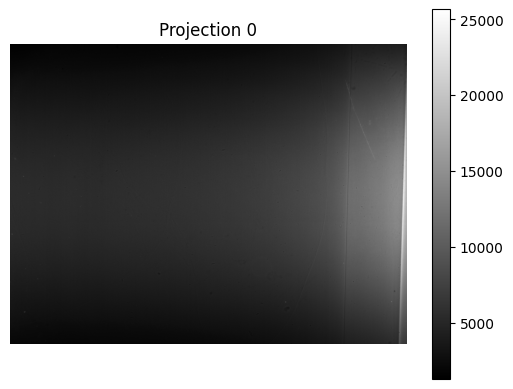

In [11]:
def display_slice(slice, title='Slice', cmap='gray', vmin=None, vmax=None, colorbar=False):
    """
    Display a slice with matplotlib dans un 1:1 aspect ratio

    Parameters
    ----------
    slice : numpy array
        Slice to display
    title : str
        Title of the plot
    cmap : str
        Color map to use

    Returns
    -------
    None
    
    """
    import matplotlib.pyplot as plt

    plt.imshow(slice, cmap=cmap, vmin=vmin, vmax=vmax)

    plt.gca().set_aspect('equal', adjustable='box')
    plt.axis('off')

    if colorbar:
        plt.colorbar()
        
    plt.title(title)

    plt.show()

display_slice(projs[0], title='Projection 0', cmap='gray', colorbar=True)

In [3]:
### Get Center of Rotation from csv file


import pandas as pd
import os

csv_path = r"C:\Users\clement.capdeville\Documents\GitHub\SOLEIL25\part_info.csv"
part_info = pd.read_csv(csv_path)
filtered_info = part_info.loc[part_info["Path"] == os.path.basename(projs_path).split(".")[0]]
CoR = filtered_info["CoR"].values[0] if not filtered_info.empty else None
angle_padding = filtered_info["Angle"].values[0] if not filtered_info.empty else None

print("CoR:", CoR)
print("Angle padding:", angle_padding)

CoR: 335.787505068283
Angle padding: 0.1264044943820224


In [12]:
### Preprocessing

import numpy as np
from tqdm import tqdm
from joblib import Parallel, delayed

def preprocess(proj, dark, flat):

    num = proj - dark
    den = flat - dark
    
    den[den == 0] = 1e-12
    
    return num / den

projs = np.array(Parallel(n_jobs=-1, backend='threading')(
    delayed(preprocess)(proj, dark, flat) 
    for proj in tqdm(projs, desc='Preprocessing projections')))

display_slice(projs[0], title='Preprocessed projection 0', cmap='gray', colorbar=True)

Preprocessing projections:   0%|          | 0/3600 [00:00<?, ?it/s]

ValueError: operands could not be broadcast together with shapes (1200,1472) (1548,2045) 

napari.manifest -> 'multipaganinproject' could not be imported: The name field in the manifest ('multipaganin-plugin') must match the package name ('multipaganinproject')


Generalized Paganin method


100%|██████████| 2850/2850 [01:35<00:00, 29.92it/s]


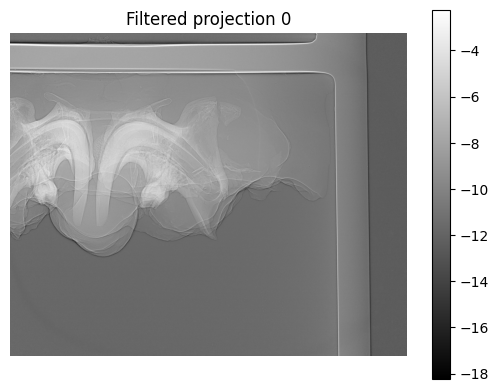

In [ ]:
''' Paganin phase retrieval implementation 
'''

import cupy as cp
from cupy.fft import fft2, ifft2

__all__ = ['paganin_filter', ]

BOLTZMANN_CONSTANT = 1.3806488e-16  # [erg/k]
SPEED_OF_LIGHT = 299792458e+2  # [cm/s]
PI = 3.14159265359
PLANCK_CONSTANT = 6.58211928e-19  # [keV*s]


def _wavelength(energy):
    return 2 * PI * PLANCK_CONSTANT * SPEED_OF_LIGHT / energy


def paganin_filter(
        data, pixel_size, dist, energy, db, W, pad, alpha=1e-3, method='Gpaganin'):
    """
    Perform single-step phase retrieval from phase-contrast measurements
    :cite:`Paganin:02`.

    Parameters
    ----------
    tomo : ndarray
        3D tomographic data.
    pixel_size : float, optional
        Detector pixel size in cm.
    dist : float, optional
        Propagation distance of the wavefront in cm.
    energy : float, optional
        Energy of incident wave in keV.
    alpha : float, optional
        Regularization parameter for Paganin method.
    method : string
        phase retrieval method. Standard Paganin or Generalized Paganin.
    db : float, optional
        delta/beta for generalized Paganin phase retrieval 
    W :  float
        Characteristic transverse lenght scale    	
    pad : bool, optional
        If True, extend the size of the projections by padding with zeros.
    Returns
    -------
    ndarray
        Approximated 3D tomographic phase data.
    """

    # New dimensions and pad value after padding.
    py, pz, val = _calc_pad(data, pixel_size, dist, energy, pad)

    # Compute the reciprocal grid.
    dx, dy, dz = data.shape
    if method == 'paganin':
        w2 = _reciprocal_grid(pixel_size, dy + 2 * py, dz + 2 * pz)
        phase_filter = cp.fft.fftshift(
            _paganin_filter_factor(energy, dist, alpha, w2))
    elif method == 'Gpaganin':
        print('Generalized Paganin method')
        kf = _reciprocal_gridG(pixel_size, dy + 2 * py, dz + 2 * pz)
        phase_filter = cp.fft.fftshift(
            _paganin_filter_factorG(energy, dist, kf, pixel_size, db, W))
    prj = cp.full((dy + 2 * py, dz + 2 * pz), val, dtype=data.dtype)
    _retrieve_phase(data, phase_filter, py, pz, prj, pad)

    return -db * data * 0.5


def _retrieve_phase(data, phase_filter, px, py, prj, pad):
    dx, dy, dz = data.shape
    num_jobs = data.shape[0]
    normalized_phase_filter = phase_filter / phase_filter.max()

    for m in tqdm(range(num_jobs)):

        prj[px:dy + px, py:dz + py] = cp.asarray(data[m])
        prj[:px] = prj[px]
        prj[-px:] = prj[-px-1]
        prj[:, :py] = prj[:, py][:, cp.newaxis]
        prj[:, -py:] = prj[:, -py-1][:, cp.newaxis]
        fproj = fft2(prj)
        fproj *= normalized_phase_filter
        proj = cp.real(ifft2(fproj))
        if pad:
            proj = proj[px:dy + px, py:dz + py]
        data[m] = proj.get()


def _calc_pad(data, pixel_size, dist, energy, pad):
    """
    Calculate new dimensions and pad value after padding.

    Parameters
    ----------
    data : ndarray
        3D tomographic data.
    pixel_size : float
        Detector pixel size in cm.
    dist : float
        Propagation distance of the wavefront in cm.
    energy : float
        Energy of incident wave in keV.
    pad : bool
        If True, extend the size of the projections by padding with zeros.

    Returns
    -------
    int
        Pad amount in projection axis.
    int
        Pad amount in sinogram axis.
    float
        Pad value.
    """
    dx, dy, dz = data.shape
    wavelength = _wavelength(energy)
    py, pz, val = 0, 0, 0
    if pad:
        val = _calc_pad_val(data)
        py = _calc_pad_width(dy, pixel_size, wavelength, dist)
        pz = _calc_pad_width(dz, pixel_size, wavelength, dist)

    return py, pz, val


def _paganin_filter_factor(energy, dist, alpha, w2):
    return 1 / (_wavelength(energy) * dist * w2 / (4 * PI) + alpha)


def _paganin_filter_factorG(energy, dist, kf, pixel_size, db, W):
    """
        Generalized phase retrieval method
        Paganin et al 2020
        diffracting feature ~2*pixel size
    """
    aph = db*(dist*_wavelength(energy))/(4*PI)
    return 1 / (1.0 - (2*aph/(W**2))*(kf-2))


def _calc_pad_width(dim, pixel_size, wavelength, dist):
    pad_pix = cp.ceil(PI * wavelength * dist / pixel_size ** 2)
    return int((pow(2, cp.ceil(cp.log2(dim + pad_pix))) - dim) * 0.5)


def _calc_pad_val(data):
    return float(cp.mean((data[..., 0] + data[..., -1]) * 0.5))


def _reciprocal_grid(pixel_size, nx, ny):
    """
    Calculate reciprocal grid.

    Parameters
    ----------
    pixel_size : float
        Detector pixel size in cm.
    nx, ny : int
        Size of the reciprocal grid along x and y axes.

    Returns
    -------
    ndarray
        Grid coordinates.
    """
    # Sampling in reciprocal space.
    indx = _reciprocal_coord(pixel_size, nx)
    indy = _reciprocal_coord(pixel_size, ny)
    cp.square(indx, out=indx)
    cp.square(indy, out=indy)

    idx, idy = cp.meshgrid(indy, indx)
    return idx + idy


def _reciprocal_gridG(pixel_size, nx, ny):
    """
    Calculate reciprocal grid for Generalized Paganin method.

    Parameters
    ----------
    pixel_size : float
        Detector pixel size in cm.
    nx, ny : int
        Size of the reciprocal grid along x and y axes.

    Returns
    -------
    ndarray
        Grid coordinates.
    """
    # Considering diffracting feature ~2*pixel size
    # Sampling in reciprocal space.
    indx = cp.cos(_reciprocal_coord(pixel_size, nx)*2*PI*pixel_size)
    indy = cp.cos(_reciprocal_coord(pixel_size, ny)*2*PI*pixel_size)
    idx, idy = cp.meshgrid(indy, indx)
    return idx + idy


def _reciprocal_coord(pixel_size, num_grid):
    """
    Calculate reciprocal grid coordinates for a given pixel size
    and discretization.

    Parameters
    ----------
    pixel_size : float
        Detector pixel size in cm.
    num_grid : int
        Size of the reciprocal grid.

    Returns
    -------
    ndarray
        Grid coordinates.
    """
    n = num_grid - 1
    rc = cp.arange(-n, num_grid, 2, dtype=cp.float32)
    rc *= 0.5 / (n * pixel_size)
    return rc

viewer = napari.Viewer()


data_filtered = paganin_filter(
    projs,
    pixel_size=12e-4,   # taille de pixel en cm (par ex. 1 µm = 1e-4 cm)
    dist=120,           # distance de propagation en cm
    energy=40,         # énergie en keV
    method='Gpaganin',  # ou 'Gpaganin'
    db=25,            # delta/beta pour la méthode généralisée
    W=5*12e-4,            # échelle de longueur transverse
    pad=True           # padding pour éviter les effets de bord
)

display_slice(data_filtered[0], title='Filtered projection 0', cmap='gray', colorbar=True)

In [5]:
import napari

viewer = napari.Viewer()
viewer.add_image(data_filtered, name='Projections')

napari.manifest -> 'multipaganinproject' could not be imported: The name field in the manifest ('multipaganin-plugin') must match the package name ('multipaganinproject')


<Image layer 'Projections' at 0x1e7025cec60>

delta/beta: 130.76923076923077


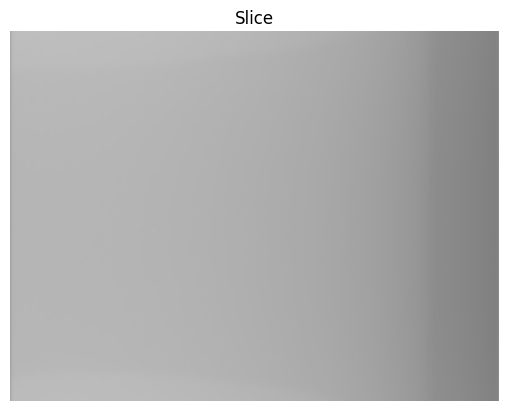

<Image layer 'Projections' at 0x1e7040c4200>

In [ ]:
import math
import cupy as cp
import numpy as np
from numpy import pi
from tqdm import tqdm

def keVtoLambda(energy_kev):
    h = 6.62607015e-34  # J.s
    c = 299792458  # m/s
    energy_joules = energy_kev * 1e3 * 1.60218e-19  # J
    return h * c / energy_joules

def get_padding_size(image, energy, effective_pixel_size, distance):
    ny, nx = image.shape
    wavelength = keVtoLambda(energy)
    n_margin = math.ceil(3 * wavelength * distance / (2 * effective_pixel_size**2))
    nx_margin = nx + 2 * n_margin
    ny_margin = ny + 2 * n_margin
    nx_padded = 2 ** math.ceil(math.log2(nx_margin))
    ny_padded = 2 ** math.ceil(math.log2(ny_margin))
    return nx_padded, ny_padded

def padding(image, nx_padded, ny_padded):
    ny, nx = image.shape
    top = (ny_padded - ny) // 2
    bottom = ny_padded - ny - top
    left = (nx_padded - nx) // 2
    right = nx_padded - nx - left
    return cp.pad(image, ((top, bottom), (left, right)), mode='reflect')

def compute_uv_squared(shape, pixel_size):
    ny, nx = shape
    pixel_size = pixel_size
    u = cp.fft.fftshift(cp.fft.fftfreq(ny, d=pixel_size))
    v = cp.fft.fftshift(cp.fft.fftfreq(nx, d=pixel_size))
    u, v = cp.meshgrid(u, v, indexing='ij')
    return u**2 + v**2

def paganin_filter(sample_images, energy_kev, pixel_size, delta_beta, dist_object_detector, beta):
    lambda_energy = keVtoLambda(energy_kev)
    waveNumber = 2 * pi / lambda_energy
    mu = 2 * beta * waveNumber

    fftNum = cp.fft.fftshift(cp.fft.fft2(sample_images))
    uv_sqrd = compute_uv_squared(fftNum.shape, pixel_size)

    denominator = 

    # denominator = 1 + (lambda_energy * dist_object_detector * delta_beta * uv_sqrd / (4 * pi))
    # denominator = 1 + pi * delta_beta * dist_object_detector * lambda_energy * uv_sqrd
    denominator[denominator == 0] = cp.finfo(float).eps

    tmpThickness = cp.fft.ifft2(fftNum / denominator)
    img_thickness = cp.real(tmpThickness)
    img_thickness = -cp.asnumpy(cp.log(img_thickness) / mu) * 1e6
    img_thickness[img_thickness <= 0] = 1e-12

    return img_thickness

def process_projection(proj, energy, distance, beta, delta, pixel_size, nx_padded, ny_padded):
    padded_proj = padding(cp.asarray(proj), nx_padded, ny_padded)
    retrieved_proj = paganin_filter(padded_proj, energy, pixel_size, delta/beta, distance, beta)
    
    ny, nx = proj.shape
    y_margin = (ny_padded - ny) // 2
    x_margin = (nx_padded - nx) // 2
    return retrieved_proj[y_margin:y_margin+ny, x_margin:x_margin+nx]

# === Paramètres ===
energy = 40  # keV
effective_pixel_size = 11.5e-6  # m
distance = 1.2  # m
pixel_size = 12e-6  # m
delta = 1.7e-6
beta = 1.3e-8

nx = projs.shape[1]
ny = projs.shape[2]
nx_padded, ny_padded = get_padding_size(projs[0], energy, effective_pixel_size, distance)

print("delta/beta:", delta/beta)

proj = process_projection(
    projs[0],
    energy, distance,
    beta, delta, pixel_size,
    nx_padded, ny_padded
)

# retrieved_projs = np.zeros_like(projs, dtype=np.float32)
# for i in tqdm(range(projs.shape[0])):
#     retrieved_projs[i] = process_projection(
#         projs[i],
#         energy, effective_pixel_size, distance,
#         beta, delta, pixel_size,
#         nx_padded, ny_padded, uv_sqrd
#     )

display_slice(proj)

viewer = napari.Viewer()
viewer.add_image(proj, name='Projections')


In [ ]:
import napari

napari.view_image(retrieved_projs)

In [ ]:
### Double Flatfield Correction

def double_flatfield_correction(projs):
    """
    Apply double flat-field correction to an image.

    Parameters
    ----------
    proj : 2D numpy array
        Image to correct

    Returns
    -------
    I_corr : 2D numpy array
        Corrected image

    """

    mean_proj = np.mean(projs, axis=0)

    mean_proj[mean_proj == 0] = 1e-6

    I_corr = projs / mean_proj

    return I_corr


double_flatfield_projs = double_flatfield_correction(retrieved_projs)


In [ ]:
min = np.min(double_flatfield_projs)
max = np.max(double_flatfield_projs)

print(min, max)

normed_projs = (double_flatfield_projs - min) / (max - min)

In [ ]:
from tqdm import tqdm

def normalize_proj_mean(projs):

    global_mean = np.mean([np.mean(proj) for proj in projs])
    print("Global mean:", global_mean)

    normalized_proj = []
    for proj in tqdm(projs, desc="Normalizing projections"):
        mean = np.mean(proj)
        if mean == 0:
            mean = 1
        normalized_proj.append(proj * global_mean / mean)

    return np.array(normalized_proj)

normed_projs = normalize_proj_mean(double_flatfield_projs)

In [ ]:
import napari

viewer = napari.Viewer()
viewer.add_image(double_flatfield_projs, name='Projections')
# viewer.add_image(normed_projs, name='Normed Projections')

In [6]:
### Retrieve the sinogram

from joblib import Parallel, delayed
from tqdm import tqdm
import gc
import napari

import numpy as np

def apply_left_weighting(projs, CoR):
    """
    Applique un poids linéaire sur la partie gauche des projections.
    """
    weights = np.linspace(0, 1, CoR)[None, None, :] 

    projs[:, :, :CoR] *= weights

    return projs 
   

def create_sinogram_slice(projs, CoR, slice_idx):
    """
    Create a sinogram from a set of projections.
    """
    theta, nx, ny = projs.shape

    sino = np.zeros((theta//2, 2 * ny - CoR))

    flip = projs[:theta // 2, slice_idx, ::-1]  # np.flip optimisé
    
    sino[:, :ny] += flip
    sino[:,  -ny:] += projs[theta//2:, slice_idx, :]

    return sino

def create_sinogram(projs, CoR):
    """
    Create sinograms from a set of projections.
    """

    projs_weighted = apply_left_weighting(projs, CoR)

    sinos = np.array(
        Parallel(n_jobs=-1, backend='threading')(
            delayed(create_sinogram_slice)(projs_weighted, CoR, slice_idx)
            for slice_idx in tqdm(range(projs.shape[1]), desc='Creating sinograms')
        )
    )

    return sinos

sinogram = create_sinogram(data_filtered, round(2*CoR))
print("Sinogram shape:", sinogram.shape)

Creating sinograms: 100%|██████████| 1200/1200 [00:05<00:00, 238.96it/s]


Sinogram shape: (1200, 1425, 2272)


In [ ]:
import napari

viewer = napari.Viewer()
viewer.add_image(sinogram, name='Sinogram')

In [ ]:
import tifffile

tifffile.imwrite(r"C:\Users\clement.capdeville\Desktop\test2.tif", sinogram[50].astype(np.float32), imagej=True)

In [7]:
import numpy as np
from numpy import pi

def from_degress_to_radians(angles):
    return angles * pi / 180

def from_radians_to_degrees(angles):
    return angles * 180 / pi

# angles = from_degress_to_radians(np.linspace(0, (sinogram.shape[1] - 1) * angle_padding, sinogram.shape[1], endpoint=False))
angles = np.linspace(0, pi, sinogram.shape[1], endpoint=False)

print("Angles shape:", angles)


Angles shape: [0.00000000e+00 2.20462642e-03 4.40925285e-03 ... 3.13497877e+00
 3.13718340e+00 3.13938803e+00]


In [8]:
### Reconstruction

from skimage.draw import disk
import astra

def reconstruct_from_sinogram_slice(sinogram, angles):
    """
    Reconstruct a 2D image from a sinogram using FBP_CUDA algorithm from ASTRA Toolbox.

    Parameters:
    - sinogram: 2D numpy array (angles, detectors) containing the sinogram.
    - angles: 1D numpy array of rotation angles (in radians).

    Returns:
    - reconstruction: 2D numpy array representing the reconstructed image.
    """

    # Définition des géométries de projection et du volume
    proj_geom = astra.create_proj_geom('parallel', 1.0, sinogram.shape[1], angles)
    vol_geom = astra.create_vol_geom(sinogram.shape[1], sinogram.shape[1])

    # Création des objets de données pour le sinogramme et la reconstruction
    sinogram_id = astra.data2d.create('-sino', proj_geom, sinogram)
    rec_id = astra.data2d.create('-vol', vol_geom)

    # Configuration et exécution de l'algorithme FBP_CUDA
    cfg = astra.astra_dict('FBP_CUDA')
    cfg['ReconstructionDataId'] = rec_id
    cfg['ProjectionDataId'] = sinogram_id

    alg_id = astra.algorithm.create(cfg)
    astra.algorithm.run(alg_id)

    # Récupération et retour de la reconstruction
    reconstruction = astra.data2d.get(rec_id)

    # Libération des ressources ASTRA
    astra.algorithm.delete(alg_id)
    astra.data2d.delete(rec_id)
    astra.data2d.delete(sinogram_id)

    return reconstruction

disk_mask = np.zeros((sinogram.shape[2], sinogram.shape[2]))
rr, cc = disk((sinogram.shape[2]//2, sinogram.shape[2]//2), sinogram.shape[2] // 2)
disk_mask[rr, cc] = 1

from tqdm import tqdm
import napari

reconstruction = np.zeros((sinogram.shape[0], sinogram.shape[2], sinogram.shape[2]))
for i in tqdm(range(sinogram.shape[0]), desc='Reconstructing'):
    reconstruction[i] = reconstruct_from_sinogram_slice(sinogram[i], angles) * disk_mask

print("Reconstruction shape:", reconstruction.shape)

Reconstructing: 100%|██████████| 1200/1200 [06:21<00:00,  3.15it/s]

Reconstruction shape: (1200, 2272, 2272)


In [9]:
viewer = napari.Viewer()
viewer.add_image(reconstruction, name='Reconstruction')

<Image layer 'Reconstruction' at 0x27e4395afc0>

In [ ]:
### Save tiff format

import tifffile

tifffile.imwrite(r"C:\Users\clement.capdeville\Desktop\tooth2.tif", reconstruction.astype(np.float32))

In [ ]:
import numpy as np

np.sqrt(np.pi*keVtoLambda(40)*1.95*1000)/5.5e-6